## Creating Ancillaries

The [Regional Ancillary Suite](https://code.metoffice.gov.uk/trac/rmed/wiki/suites/RAS) is used to set domains and create ancillary data for regional models.

Suite **u-cy368** has been set up to create ancillaries for our sample domain. Check out the suite with `rosie checkout u-cy368` and open it in `rose edit`. Make sure to set the SITE to `nci-gadi` in 'General Run Options'.

### Defining Domains

Domains are defined in two layers, regions and resolutions. This allows the domain to be relocatable by just changing the region centre, without having to change the model grid setups.

At this stage we're not worried about which nest is inside which, that will get defined in the Regional Nesting Suite.

Aus2200 domains are named by their grid spacing in ten-thousandths of a degree - `d0198` represents a 0.0198 degree grid spacing in both latitude and longitude.

#### Regions

**Regions** set the primary location of the domain. You can define this either as the domain centre or as the bottom left corner. Regions also control if a rotated grid is being used. Configuration options are prefixed with the region number, e.g. `rg01_name`.

* **name**: A name for this region
* **use_centre**: True if the location is for the region centre, false for the bottom left corner
* **centre**: Region centre
* **rot_grid**: True if using a rotated pole (useful at high latitudes)

When rotated pole is enabled, the grid coordinates will be transformed so that the centre of your domain is at 0N 0E in the new coordinate system. At high latitudes this will give much more evenly spaced grid cells.

![Ancil region](images/ancil-region.png)

#### Resolutions

**Resolutions** define actual grids, including the grid size and spacing. Configuration options are prefixed with the region and resolution number, e.g. `rg01_rs01_name`.

* **name**: A name for this resolution
* **delta**: Grid spacing in degrees
* **npts**: Grid size
* **offset**: Offset from the region location
* **levset**: Vertical levels - RAL configurations should use L90_40km (90 vertical levels, max height 40 km)

![Ancil Resolution](images/ancil-resolution.png)

### Ancillary Options

There are a number of options for which ancillary files to create. Which you'll need will depend on the model's science settings. SRTM orography should be enabled when working at km-scale or finer resolutions.

### Exercise

Plan out creating ancillaries for your own domain (max 200x200 grid size)

At the boundary of the regional domain the model is merged with the driving lateral boundary conditions. The driving data always has to be a bit larger than the target domain, you can't for instance have an outer nest domain and an inner nest domain share the same edge.

Boundary data can be saved as a 'frame', where the innermost part of the data is cut out leaving only data around the edge. In this case the frame has to cover from the domain's 'halo' to the domain's 'rim' (both configurable in the model's LBC configuration).

Here's some Python code to plot out the region that may be helpful when planning your domain.

> **__NOTE__** This code and some examples are now available at 
> https://github.com/21centuryweather/UM_configuration_tools/blob/main/UM_plot_domain.ipynb
>

In [1]:
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy

def plot_region(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), rim: int=9, halo: T.Tuple[int, int]=(7,7), **kwargs):
    """
    Plots a LAM region, including its rim and halo
    """
    
    draw_box_centre_size(ax, name, centre, res, size, pole, **kwargs)
    
    rim_size = [size[0]-rim*2, size[1]-rim*2]
    draw_box_centre_size(ax, name + '_rim', centre, res, rim_size, pole, ls='--', **kwargs)
    
    halo_size = [size[0]+halo[0]*2, size[1]+halo[1]*2]
    draw_box_centre_size(ax, name + '_halo', centre, res, halo_size, pole, ls=':', **kwargs)
    
def draw_box_centre_size(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its centre and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    draw_box_corners(ax, name, corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2], pole=pole, **kwargs)
    
def draw_box_corners(ax, name: str, corners: T.Tuple[float, float, float, float], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its corners
    """
    x0,x1,y0,y1 = corners
    
    lons = numpy.linspace(x0,x1)
    lats = numpy.linspace(y0,y1)
        
    crs = ccrs.RotatedGeodetic(pole[1], pole[0])
    ax.plot(lons, [y0]*lons.size, transform=crs, **kwargs, label=name) 
    ax.plot(lons, [y1]*lons.size, transform=crs, **kwargs) 
    ax.plot([x0]*lats.size, lats, transform=crs, **kwargs) 
    ax.plot([x1]*lats.size, lats, transform=crs, **kwargs) 

Matplotlib is building the font cache; this may take a moment.


In [2]:
import iris
import iris.plot

frames_se = iris.load_cube('/scratch/nf33/saw562/nri-workshop-tutorial/barra-frames/20200119T1800Z/frame_barra-se', 'air_potential_temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


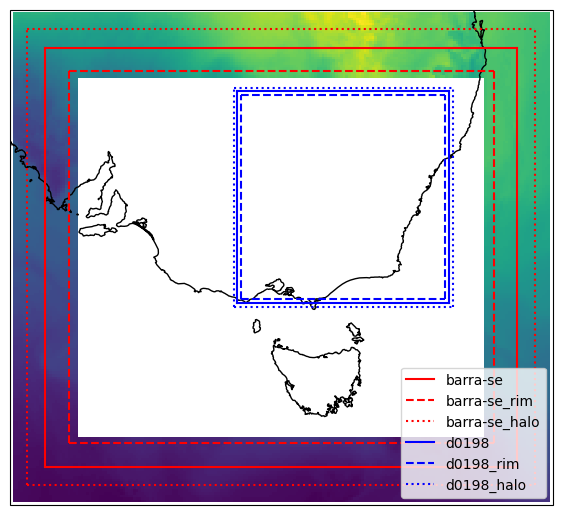

In [3]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

iris.plot.pcolormesh(frames_se[0,0,:,], axes=ax)
plot_region(ax, 'barra-se', centre=[-36.96,145.02], res=[0.11, 0.11], size=[160,180], color='r')
plot_region(ax, 'd0198', centre=[-34.43,147.615], res=[0.0198,0.0198], size=[450,450], color='b')

ax.coastlines('10m')
ax.legend(loc='lower right');

## Rotated Poles

At high latitudes a regular lat-lon grid can become very distorted. In this case you can use a rotated pole to get more evenly sized grid cells.

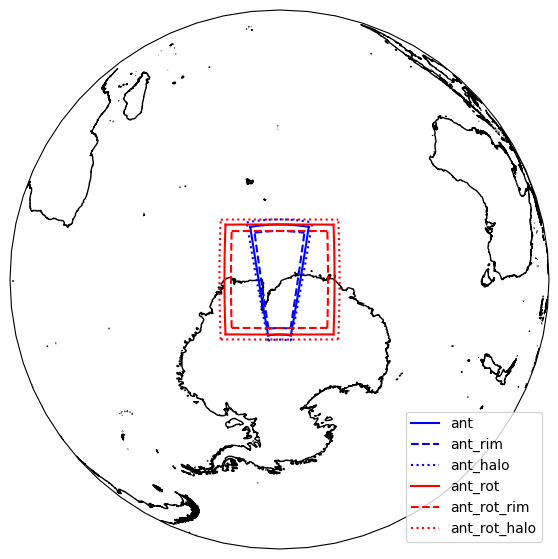

In [4]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=-68, central_longitude=78))

plot_region(ax, 'ant', centre=[-68,78], res=[0.135,0.135], size=[150,150], color='b')
plot_region(ax, 'ant_rot', centre=[0,0], res=[0.135,0.135], size=[150,150], pole=[90+68,180+78], color='r')

ax.set_global()
ax.coastlines('10m')
ax.legend(loc='lower right');

## CAP and ANTS

Ancillary files are created from high-resolution source data using two tools, [CAP](https://code.metoffice.gov.uk/doc/ancil/ancil9.1/index.html) and [ANTS](https://code.metoffice.gov.uk/doc/ancil/ants/latest/index.html). The Met Office are in the process of moving all of their ancillary generation to the python-based ANTS tool, however it doesn't yet support all ancillary types.

## Ancil files

The RAS creates the following ancillary files under `~/cylc-run/u-cy368/share/data/ancils`. You can manually edit the data in the files if needed using [ANTS](https://code.metoffice.gov.uk/doc/ancil/ants/latest/index.html).

* orog_srtm: High-resolution orography
* qrclim.biog: Biogenic aerosol climatology
* qrclim.biom: Biomass burning aerosol climatology
* qrclim.blck: Black carbon (soot) aerosol climatology
* qrclim.dust: Dust aerosol climatology
* qrclim.land: Land-surface albedo
* qrclim.ocff: Organic carbon from fossil fuel climatology
* qrclim.ozone: Ozone climatology
* qrclim.sea: Chlorophyll climatology
* qrclim.seaice: Sea ice climatology
* qrclim.smow: Soil moisture and snow climatology
* qrclim.sslt: Sea salt aerosol climatology
* qrclim.sst: Sea surface temperature climatology
* qrclim.sulp: Sulphate aerosol climatology
* qrparm.MORUSES.morph: MORUSES data
* qrparm.hydtop: Large scale hydrology TOP-index
* qrparm.lake: Lake mask
* qrparm.mask: Land-sea mask
* qrparm.orog: Orography
* qrparm.orog.mn: Mean orography
* qrparm.soil: Soil parameters
* qrparm.soil.dust: Soil dust
* qrparm.veg.dist: Disturbed fraction of vegetation
* qrparm.veg.frac: Vegetation fractions
* qrparm.veg.func: Vegetation functional types
.veg.func
qrparm.veg.func_igbp

## Editing Ancillaries

You can edit ancilliaries in Python using the ANTS package. ANTS is based on Iris, and represents ancillaries as Iris cubes.

Load the most recent version of ANTS with
```shell
module use /g/data/access/ngm/modules
module load ants
```

An example of editing the land-sea mask is:
```python
import ants

cubes = ants.load('/home/562/saw562/cylc-run/u-cy368/share/data/ancils/aus2200/d0198/qrparm.mask')
cubes.extract_strict('land_binary_mask').data[300:350,300:350] = 0
cubes.extract_strict('land_area_fraction').data[300:350,300:350] = 0
ants.save(cubes, '/home/562/saw562/cylc-run/u-cy368/share/data/ancils/aus2200/d0198/qrparm.mask.edited')
```

You should check the ancillary file to make sure the edit is what you wanted:

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/iris/coords.py:2070: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


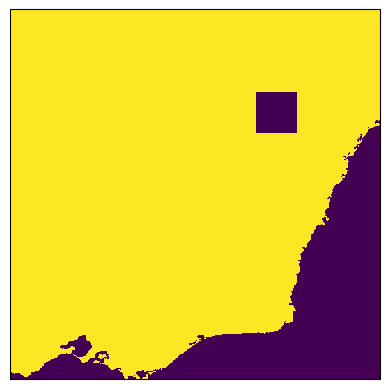

In [5]:
mask = iris.load_cube('/home/562/saw562/cylc-run/u-cy368/share/data/ancils/aus2200/d0198/qrparm.mask.edited', 'land_binary_mask')
iris.plot.pcolormesh(mask)

> **__NOTE__** To check your ancillaries have been generated correctly, you can use the following notebook:
>
>https://github.com/21centuryweather/UM_configuration_tools/blob/main/Check_UM_ancillaries.ipynb
>
>This notebook also contains logic to detect ancillary errors and it will identify missing ancillary data (i.e. 'NaNs' or 'Not-a-Number') in regions over land.
>
>Any UM forecast task will instantly fail if 'NaNs' are ingested into the forecast fields.
